In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from tqdm import tqdm


from sklearn.metrics import  roc_auc_score

import xgboost as xgb

%matplotlib inline

In [19]:
#get directory
df_train_path = os.path.join('data','df_train_scaled.csv')
df_test_path = os.path.join('data','df_test_scaled.csv')

In [20]:
df_train = pd.read_csv(df_train_path, compression='zip',index_col=0)
df_train.head()

/ichec/home/users/ikunal95/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.610627,0.172191,-0.165071,-0.326720,1.125480,0.447761,-0.425631,-1.304639,0,-0.280449,...,0,-0.544925,-1.031547,-0.312756,0,-0.506174,0.167560,-1.295442,-0.664064,0.758198
67,1.637546,1.587155,-1.679589,-1.849610,-1.094865,2.003926,0.925331,-1.304639,1,-1.129757,...,0,0.049260,1.652931,0.182998,0,1.812689,-0.286453,0.005808,-1.141442,-0.946936
109,-0.610627,0.172191,-0.165071,-0.326720,-1.094865,-1.108404,0.376406,1.110298,0,-0.280449,...,0,-0.041656,1.167090,-0.808510,0,-0.404217,-0.657446,-1.125453,-0.504937,0.757704
166,-0.610627,0.052647,-0.165071,-0.174431,-1.372409,-1.108404,-1.962332,1.110298,0,-0.280449,...,0,-0.489803,-0.990374,-0.808510,0,-1.029029,0.458129,-0.588348,0.449820,0.696767
240,-0.610627,0.359114,-0.165071,-0.479009,-1.094865,-1.108404,-0.040973,1.110298,0,-0.705103,...,0,-0.102644,0.117179,-0.808510,0,0.016681,-0.199473,-1.212870,-0.823190,0.854260


In [21]:
#target variable
target_col = 'loan_status'

#training variables
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_train=X_train.drop(columns=drop_columns)


In [22]:
df_test = pd.read_csv(df_test_path, compression='zip',index_col=0)
df_test.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.570976,-1.294606,1.356055,1.209613,0.855221,-0.986772,-0.544575,1.124050,0,1.508179,...,0,-0.840577,-2.343674,0.966999,0,0.607537,-1.476305,-1.426077,2.234328,-0.036477
78,-0.570976,-0.275277,0.592659,0.284735,1.131238,0.689685,-0.192022,-1.305284,0,2.829991,...,0,0.911808,0.468075,0.522267,0,0.561519,-0.285751,-0.499703,0.552829,0.483092
83,-0.570976,-0.835469,0.592659,0.901320,1.131238,0.689685,1.292035,1.124050,0,-0.254237,...,0,0.234027,-0.562625,0.966999,0,0.946541,0.340857,0.862879,0.889129,0.194849
123,-0.570976,2.336756,-1.697530,-1.565023,1.131238,-0.986772,0.766151,-1.305284,0,-0.254237,...,1,-0.663703,-0.356485,0.077535,1,0.315703,-1.382314,-1.716246,-0.960519,1.909040
144,1.751298,-0.275277,0.592659,0.284735,-0.524867,0.689685,-0.257746,-1.305284,1,0.626971,...,0,-0.562148,-1.547974,0.077535,0,-0.174013,0.340857,0.792449,2.234328,-2.141528


In [23]:
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col].values
drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_test =X_test.drop(columns=drop_columns)

In [24]:
X_train=X_train.values

In [25]:
y_train=y_train.values

In [26]:
X_test=X_test.values

In [27]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
auc_arr = []

for _ in tqdm(range(25)):
    idx = np.random.choice(np.arange(len(X_train)), 500_000, replace=True)
    X_temp = X_train[idx]
    y_temp = y_train[idx]
    
    #instantiate classifier
    clf = xgb.XGBClassifier(colsample_bytree=0.9, eta=0.05, max_depth=6,n_estimators=200,
                              n_jobs=-1, scale_pos_weight=estimate)
    #fit to new data
    clf.fit(X_temp, y_temp)
    
    #predictions and scoring
    y_pred = clf.predict_proba(X_test)
    score = roc_auc_score(y_test, y_pred[:,1])
    auc_arr.append(score)

  0%|          | 0/25 [00:00<?, ?it/s]

Estimate: 4.020


100%|██████████| 25/25 [1:07:27<00:00, 161.88s/it]


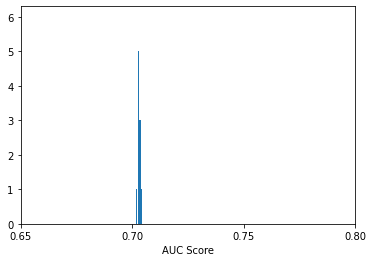

In [33]:
plt.hist(auc_arr)
plt.xlabel("AUC Score")
plt.xticks(np.arange(0.65, 0.8, 0.05))
plt.savefig(os.path.join("plots", 'auc_632_sampling.png'))
plt.show()